<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 20%;">
   

In [1]:
from IPython.display import Markdown, display
import inspect
import pathlib
import ast

def display_task_source(task_func, title):
    """Display task source code from the original file, including decorators but excluding docstrings.
    
    Only shows code from @flowtask decorator to end of function, excluding the function's docstring.
    """
    # Get the module where the function is defined
    module = inspect.getmodule(task_func)
    func_name = task_func.__name__
    
    if not module or not hasattr(module, '__file__'):
        display(Markdown(f"❌ Could not find source file for `{func_name}`"))
        return
    
    # Read the entire source file
    source_file = pathlib.Path(module.__file__)
    with open(source_file, 'r', encoding='utf-8') as f:
        file_content = f.read()
    
    # Parse the AST to find the function
    tree = ast.parse(file_content)
    
    # Find the function definition in the AST
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef) and node.name == func_name:
            # Get line numbers (1-indexed)
            start_line = node.lineno
            end_line = node.end_lineno
            
            # Read the lines
            lines = file_content.splitlines()
            
            # Look backwards from function def to find @flowtask decorator
            decorator_start = start_line - 1  # Convert to 0-indexed
            while decorator_start > 0:
                line = lines[decorator_start - 1].strip()
                if line.startswith('@flowtask'):
                    break
                decorator_start -= 1
            
            # Extract from decorator to end of function
            source_lines = lines[decorator_start - 1:end_line]
            
            # Now remove the docstring if present
            # The docstring is the first statement in the function body
            if node.body and isinstance(node.body[0], ast.Expr) and isinstance(node.body[0].value, ast.Constant):
                if isinstance(node.body[0].value.value, str):
                    # Found a docstring - get its line range
                    docstring_start = node.body[0].lineno - 1  # Convert to 0-indexed
                    docstring_end = node.body[0].end_lineno - 1  # Convert to 0-indexed
                    
                    # Calculate relative positions in source_lines array
                    relative_doc_start = docstring_start - (decorator_start - 1)
                    relative_doc_end = docstring_end - (decorator_start - 1)
                    
                    # Remove docstring lines from source_lines
                    source_lines = source_lines[:relative_doc_start] + source_lines[relative_doc_end + 1:]
            
            source_code = '\n'.join(source_lines)
            
            # Display as markdown
            markdown_content = f"""---

### `{func_name}`

```python
{source_code}
```
"""
            display(Markdown(markdown_content))
            return
    
    # Fallback if AST parsing fails
    display(Markdown(f"❌ Could not parse function `{func_name}` from source file"))


# CADSYNTH - MFR Part face Classification using HOOPS AI


In [2]:
import hoops_ai
import os

hoops_ai.set_license(hoops_ai.use_test_license(), validate=False)



HOOPS AI version :  1.0.0-b2dev3 



C:\Users\LuisSalazar\AppData\Local\Temp\ipykernel_34484\512963169.py:4: UserWarning: ⚠️ TEST LICENSE expires in 5 days (January 31, 2026)!
   Please obtain your own license from Tech Soft 3D.
   Visit: https://www.techsoft3d.com/contact/
  hoops_ai.set_license(hoops_ai.use_test_license(), validate=False)


In [3]:
# Using a test flow name for 10-file test
from cad_tasks_cadsynth import get_flow_name
flow_name = get_flow_name()
print(f"Flow name: {flow_name}")

2026-01-25 18:31:09 | INFO | numexpr.utils | NumExpr defaulting to 16 threads.


HOOPS AI version :  1.0.0-b2dev3 

Flow name: ETL_CADSYNTH_training_b2


In [4]:
import os
import pathlib
from typing import Tuple, List

# Import the flow builder framework from the library
import hoops_ai
from hoops_ai.flowmanager import flowtask


from hoops_ai.cadaccess import HOOPSLoader, HOOPSTools
from hoops_ai.cadencoder import BrepEncoder
from hoops_ai.dataset import DatasetExplorer
from hoops_ai.storage import DataStorage, CADFileRetriever, LocalStorageProvider
from hoops_ai.storage.datasetstorage.schema_builder import SchemaBuilder

## Configuring Setup

In [5]:
# Configuration - Using simpler paths
nb_dir = pathlib.Path.cwd()
flows_outputdir = nb_dir.joinpath("out")
# Import task functions from external module for ProcessPoolExecutor compatibility
from cad_tasks_cadsynth import gather_cadsynth_files, encode_data_for_ml_training, my_workflow_for_cadsynth, get_flow_name

## ETL Data pipeline


In [6]:
# data source
nb_dir = pathlib.Path.cwd()

datasources_dir = [nb_dir.parent.joinpath("packages","cadfiles","cadsynth100","step")]


In [7]:
display_task_source(gather_cadsynth_files, "gather_cadsynth_files")

---

### `gather_cadsynth_files`

```python
@flowtask.extract(
    name="gather cadsynth files",
    inputs=["cad_datasources"],
    outputs=["cad_dataset"],
    parallel_execution=True
)
def gather_cadsynth_files(source: str) -> List[str]:

    # Example 1: Basic retrieval with format filtering
    retriever = CADFileRetriever(
        storage_provider=LocalStorageProvider(directory_path=source),
        formats=[".stp", ".step", ".iges", ".igs"],
        #filter_pattern="*5*"  # Only files with "5" in name
    )
            
    # Get files using the library's retriever
    source_files = retriever.get_file_list()
    
    # Shuffle to get random sample instead of first N files in order
    import random
    random.seed(42)  # For reproducibility
    shuffled_files = source_files.copy()
    random.shuffle(shuffled_files)
    
    return shuffled_files #[:100]
```


# Data Transformation : Encoded data to be used as ml input

In [8]:
display_task_source(encode_data_for_ml_training, "encode_data_for_ml_training")

---

### `encode_data_for_ml_training`

```python
@flowtask.transform(
    name="Preparing data for Exploring and ML training",
    inputs=["cad_dataset"],
    outputs=["cad_files_encoded"],
    parallel_execution=True
)
def encode_data_for_ml_training(cad_file: str, cad_loader :  HOOPSLoader, storage : DataStorage) -> str:
    import numpy as np
    import random

    cad_model = cad_loader.create_from_file(cad_file)
    storage.set_schema(cad_schema)

    facecount, edgecount = my_workflow_for_cadsynth.encode_cad_data(cad_file, cad_loader, storage)
    
    # Add label data
    file_name = pathlib.Path(cad_file).stem  # Get base name without extension
    label_file = pathlib.Path(cad_file).parent.parent / "label" / f"{file_name}.json"
    
    # Load and extract labels from JSON file
    with open(label_file, 'r') as f:
        data = json.load(f)
    label_codes = data.get("labels", [])
    
    
    
    
    
    # Save label data in the schema-defined group for dataset analytics
    storage.save_data("Labels/face_labels", np.array(label_codes))

    
    # ALSO save label using the key expected by GraphClassification.convert_encoded_data_to_graph
    # This is required for the DGL graph files to have the correct labels
    storage.save_data("face_labels", np.array(label_codes))
    
    #
    dgl_storage = DGLGraphStoreHandler()

    # DGL graph Bin file
    item_no_suffix = pathlib.Path(cad_file).with_suffix("")  # Remove the suffix to get the base name
    hash_id = generate_unique_id_from_path(str(item_no_suffix))
    dgl_output_path = pathlib.Path(flows_outputdir).joinpath("flows", flow_name, "dgl", f"{hash_id}.ml")  
    dgl_output_path.parent.mkdir(parents=True, exist_ok=True)

    my_workflow_for_cadsynth.convert_encoded_data_to_graph(storage, dgl_storage, str(dgl_output_path))
    
    # Save file-level metadata (will be routed to .infoset)
    storage.save_metadata("Item", str(cad_file))
    storage.save_metadata("source", "CADSYNTH")
    
    # Compress the storage into a .data file
    storage.compress_store()
    
    # Return the base storage path
    return storage.get_file_path("")
```


## Pipeline execution

In [9]:
# Create and run the Data Flow
flow_name = get_flow_name()
cad_flow = hoops_ai.create_flow(
    name=flow_name,
    tasks=[gather_cadsynth_files, encode_data_for_ml_training],
    max_workers=3,
    flows_outputdir=str(flows_outputdir),
    ml_task="Part Segmentation or Part Face Classification",
    #debug = True,
    auto_dataset_export=True,  # Enable automatic dataset merging
    export_visualization=False  # Disable visualization export
)

# Run the flow to process all files
print("Starting flow execution with parallel processing...")
flow_output, output_dict, flow_file = cad_flow.process(inputs={'cad_datasources': datasources_dir}, clean_ouput_dir = True)

# Display results
print("\n" + "="*70)
print("FLOW EXECUTION COMPLETED SUCCESSFULLY")
print("="*70)
print(f"\nDataset files created:")
print(f"  Main dataset: {output_dict.get('flow_data', 'N/A')}")
print(f"  Info dataset: {output_dict.get('flow_info', 'N/A')}")
print(f"  Attributes: {output_dict.get('flow_attributes', 'N/A')}")
print(f"  Flow file: {flow_file}")
print(f"\nTotal processing time: {output_dict.get('Duration [seconds]', {}).get('total', 0):.2f} seconds")
print(f"Files processed: {output_dict.get('file_count', 0)}")


Starting flow execution with parallel processing...
|INFO| FLOW | ######### Flow 'ETL_CADSYNTH_training_b2' start #######
|WARNING| FLOW | Cleaning up existing flow directory: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2
|WARNING| FLOW | Removing all previous outputs for flow 'ETL_CADSYNTH_training_b2' to avoid build conflicts.
|INFO| FLOW | Flow directory successfully cleaned and recreated: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2
|INFO| FLOW | 
Flow Execution Summary
|INFO| FLOW | ==================================================
|INFO| FLOW | Task 1: gather cadsynth files
|INFO| FLOW |     Inputs : cad_datasources
|INFO| FLOW |     Outputs: cad_dataset
|INFO| FLOW | Task 2: Preparing data for Exploring and ML training
|INFO| FLOW |     Inputs : cad_dataset
|INFO| FLOW |     Outputs: cad_files_encoded
|INFO| FLOW | Task 3: AutoDatasetExportTask
|INFO| FLOW |     Inputs : cad_fil

DATA INGESTION:   0%|                                                                            | 0/1 [00:00<…

|INFO| FLOW | Executing ParallelTask 'Preparing data for Exploring and ML training' with 101 items.


DATA TRANSFORMATION:   0%|                                                                     | 0/101 [00:00<…

|INFO| FLOW | Executing SequentialTask 'AutoDatasetExportTask'.
[DatasetMerger] Saved schema with 5 groups to metadata.json
|INFO| FLOW | Auto dataset export completed in 24.78 seconds
Sequential Task end=====================
|INFO| FLOW | Time taken: 223.11 seconds
|INFO| FLOW | ######### Flow 'ETL_CADSYNTH_training_b2' end ######

FLOW EXECUTION COMPLETED SUCCESSFULLY

Dataset files created:
  Main dataset: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2\ETL_CADSYNTH_training_b2.dataset
  Info dataset: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2\ETL_CADSYNTH_training_b2.infoset
  Attributes: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2\ETL_CADSYNTH_training_b2.attribset
  Flow file: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out/flows/ETL_CADSYNTH_training_b2/ETL_CADSYNTH_training_b2.flow

Total processing time: 223.1

## Data Serving : Analytics

In [10]:
# Explore the generated dataset
explorer = DatasetExplorer(flow_output_file=str(flow_file))
explorer.print_table_of_contents()

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:50565' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/101 [00:00<?, ?it/s]


--- Dataset Table of Contents ---

LABELS_GROUP:
  FACE_LABELS_DATA: Shape: (2796,), Dims: ('Labels_face_labels_dim_0',), Size: 2796
  FILE_ID_CODE_LABELS_DATA: Shape: (2796,), Dims: ('Labels_face_labels_dim_0',), Size: 2796

EDGES_GROUP:
  EDGE_CONVEXITIES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_DIHEDRAL_ANGLES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_INDICES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_LENGTHS_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_TYPES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_U_GRIDS_DATA: Shape: (7269, 5, 6), Dims: ('edge', 'dim_x', 'component'), Size: 218070
  FILE_ID_CODE_EDGES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269

FACEFACE_GROUP:
  A3_DISTANCE_DATA: Shape: (87426, 64), Dims: ('faceface_index', 'face_y'), Size: 5595264
  D2_DISTANCE_DATA: Shape: (87426, 64), Dims: ('faceface_index', 'face_y'), Size: 5595264
  EXTENDED_ADJACENCY_DATA: Shape: (87426,), Dims: ('faceface_ind

## ML-Ready Dataset Preparation

The `DatasetLoader` provides tools for preparing the merged dataset for machine learning:

### Key Capabilities:
- **Stratified Splitting**: Create train/validation/test splits while preserving class distributions
- **Subset Tracking**: Records file assignments in the dataset metadata

In [11]:
print(explorer.available_groups())

{'graph', 'Labels', 'faceface', 'faces', 'edges'}


In [12]:
print(explorer.available_arrays('Labels'))

{'face_labels', 'file_id_code_Labels'}


In [13]:
# Visualization libraries
import matplotlib.pyplot as plt

def print_distribution_info(dist, title="Distribution"):
    """Helper function to print and visualize distribution data."""
    list_filecount = list()
    for i, bin_files in enumerate(dist['file_id_codes_in_bins']):
        list_filecount.append(bin_files.size)

    dist['file_count'] =list_filecount
    # Visualization with matplotlib
    fig, ax = plt.subplots(figsize=(12, 4))
    
    bin_centers = 0.5 * (dist['bin_edges'][1:] + dist['bin_edges'][:-1])
    ax.bar(bin_centers, dist['file_count'], width=(dist['bin_edges'][1] - dist['bin_edges'][0]), 
           alpha=0.7, color='steelblue', edgecolor='black', linewidth=1)
    
    # Add file count annotations
    for i, count in enumerate(dist['file_count']):
        if count > 0:  # Only annotate non-empty bins
            ax.text(bin_centers[i], count + 0.5, f"{count}", 
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title(f'{title} Histogram')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

MFR Labels distribution created in 2.43 seconds



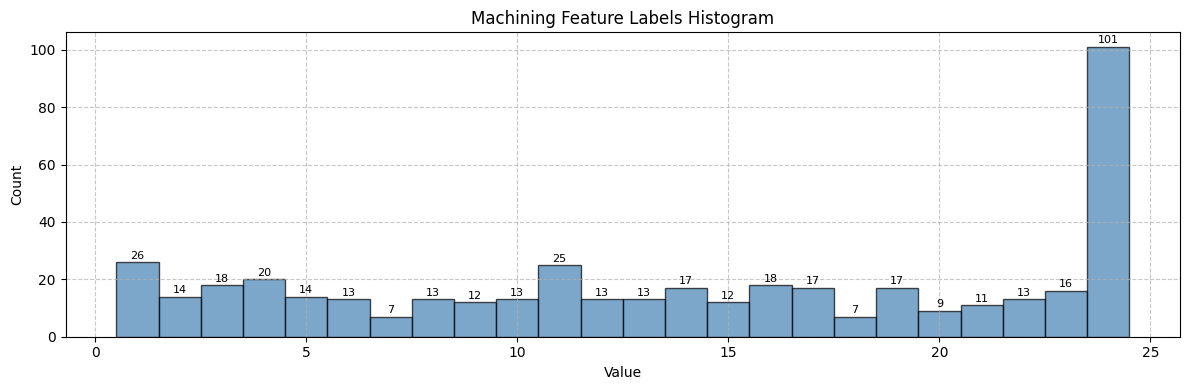

In [14]:
import time
start_time = time.time()
face_dist = explorer.create_distribution(key="face_labels", bins=None, group="Labels")
print(f"MFR Labels distribution created in {(time.time() - start_time):.2f} seconds\n")
print_distribution_info(face_dist, title="Machining Feature Labels")

## Dataset Visualization with DatasetViewer

The **DatasetViewer** is a powerful visualization tool that bridges dataset queries and visual analysis. It enables you to quickly visualize query results in two ways:

1. **Image Grids**: Generate collages of PNG previews for rapid visual scanning
2. **Interactive 3D Views**: Open inline 3D viewers for detailed model inspection

In [15]:
# Import the DatasetViewer from the insights module
from hoops_ai.insights import DatasetViewer

# Create a DatasetViewer using the convenience method from_explorer
# This method queries the explorer and builds the file ID to visualization path mappings
dataset_viewer = DatasetViewer.from_explorer(explorer)

2026-01-25 18:35:09 | INFO | hoops_ai.insights.dataset_viewer | Initialized process pool with 4 workers
2026-01-25 18:35:09 | INFO | hoops_ai.insights.dataset_viewer | DatasetViewer initialized with reference directory: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2
2026-01-25 18:35:09 | INFO | hoops_ai.insights.dataset_viewer | Built file mapping for 101 files


In [16]:
start_time = time.time()

# condition
label_is_frequent = lambda ds: ds['face_labels'] == 23

filelist = explorer.get_file_list(group="Labels", where=label_is_frequent)
print(f"Filtering completed in {(time.time() - start_time):.2f} seconds")
print(len(filelist))

Filtering completed in 0.08 seconds
16


### Example 1: Visualize Query Results as Image Grid

Now let's use the query results we obtained earlier and visualize them as a grid of images. This is perfect for quickly scanning through many files to understand patterns or identify specific cases.

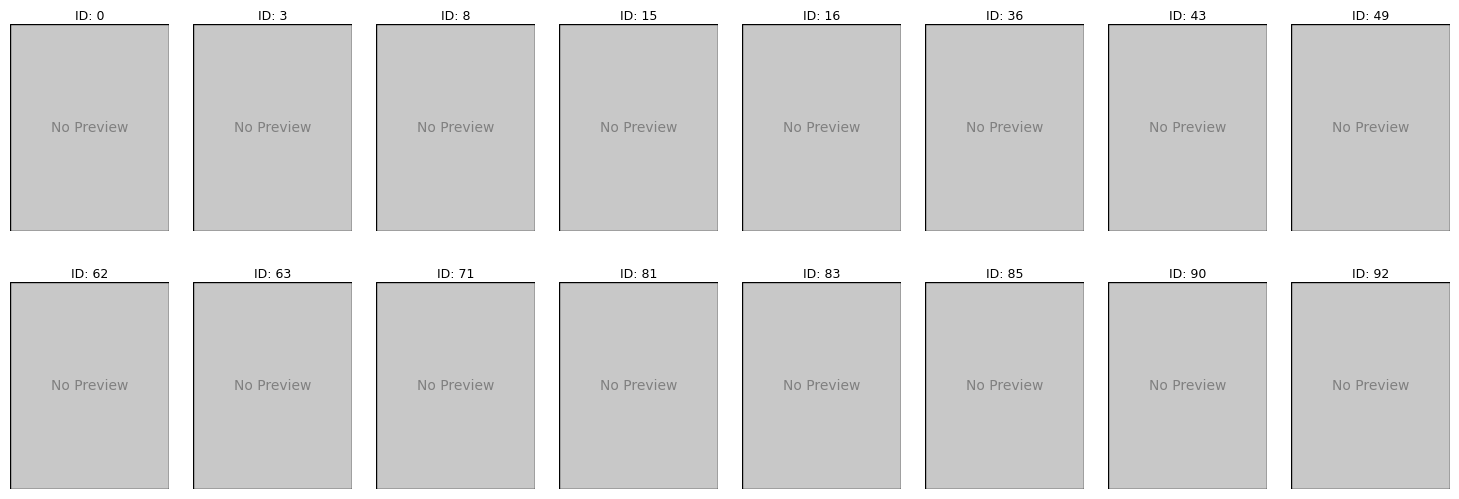

In [17]:
# Visualize the filtered files as a 5x5 grid with file IDs as labels
fig = dataset_viewer.show_preview_as_image(
    filelist, 
    k=25,                      # Show up to 25 files
    grid_cols=8,               # 5 columns
    label_format='id',         # Show file IDs as labels
    figsize=(15, 5)           # Larger figure size
)

plt.show()

# Machine Learning Training

In [18]:
# Load and split dataset for machine learning
from hoops_ai.dataset import DatasetLoader

flow_path = pathlib.Path(flow_file)
loader = DatasetLoader(
    merged_store_path=str(flow_path.parent / f"{flow_path.stem}.dataset"),  
    parquet_file_path=str(flow_path.parent / f"{flow_path.stem}.infoset")
)

# Split dataset by machining category with explicit group parameter
train_size, val_size, test_size = loader.split(
    key="face_labels",
    group="Labels",  # Explicitly specify the group for clarity
    train=0.6, 
    validation=0.2, 
    test=0.2, 
    random_state=42
)

print(f"Dataset split: Train={train_size}, Validation={val_size}, Test={test_size}")

# Access training dataset
train_dataset = loader.get_dataset("train")
print(f"Training dataset ready with {len(train_dataset)} samples")

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:63630' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/101 [00:00<?, ?it/s]


DATASET STRUCTURE OVERVIEW

Group: Labels
------------------------------
  face_labels: (2796,) (float64)
  file_id_code_Labels: (2796,) (int64)

Group: edges
------------------------------
  edge_convexities: (7269,) (int32)
  edge_dihedral_angles: (7269,) (float32)
  edge_indices: (7269,) (int32)
  edge_lengths: (7269,) (float32)
  edge_types: (7269,) (int32)
  edge_u_grids: (7269, 5, 6) (float32)
  file_id_code_edges: (7269,) (int64)

Group: faceface
------------------------------
  a3_distance: (87426, 64) (float32)
  d2_distance: (87426, 64) (float32)
  extended_adjacency: (87426,) (float32)
  face_pair_edges_path: (87426, 32) (int32)
  file_id_code_faceface: (87426,) (int64)

Group: faces
------------------------------
  face_areas: (2796,) (float32)
  face_discretization: (2796, 25, 7) (float32)
  face_indices: (2796,) (int32)
  face_loops: (2796,) (int32)
  face_neighborscount: (2796,) (int32)
  face_types: (2796,) (int32)
  file_id_code_faces: (2796,) (int64)

Group: graph
--

In [19]:
from hoops_ai.ml.EXPERIMENTAL import FlowTrainer


flow_root_dir = nb_dir.joinpath("out","flows",flow_name)

In [20]:
flow_trainer = FlowTrainer(

    flowmodel       = my_workflow_for_cadsynth,
    datasetLoader   = loader,
    experiment_name = "HOOPS_AI_train",
    result_dir      = flow_root_dir,
    accelerator     = 'cpu',
    devices         = 1,
    max_epochs      = 30,
    batch_size      = 64
    )

GRAPH NODE CLASSIFICATION MODEL
Batch size adjusted to 20 to train dataset size


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trained_model_path = flow_trainer.train()
print(f"Training finished. Model checkpoint saved in {trained_model_path}")


-----------------------------------------------------------------------------------
GRAPH NODE CLASSIFICATION MODEL - TRAINING STEP
-----------------------------------------------------------------------------------
Training batch size               : 20
Adjusted learning rate (for batch): 0.002

Train set contains                : 60 samples (59.41%)
Validation set contains           : 20 samples (19.80%)
Test set contains                 : 21 samples (20.79%)
Total samples                     : 101
Max Epoch                         : 30

The trained model: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2\ml_output\HOOPS_AI_train\0125\183526\best.ckpt

To monitor the logs, run:
tensorboard --logdir results/HOOPS_AI_train/0125/183526
-----------------------------------------------------------------------------------
        


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\LuisSalazar\miniconda3\envs\hoops_ai_cpu_dev\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Training finished. Model checkpoint saved in C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2\ml_output\HOOPS_AI_train\0125\183526\best.ckpt


In [22]:
## Testing phase
flow_trainer.test(trained_model_path)
print(f"Testing finished")


-----------------------------------------------------------------------------------
GRAPH NODE CLASSIFICATION MODEL - TESTING STEP
-----------------------------------------------------------------------------------

The trained model: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2\ml_output\HOOPS_AI_train\0125\183526\best.ckpt

Test set contains 21 training samples
-----------------------------------------------------------------------------------
        


Restoring states from the checkpoint path at C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2\ml_output\HOOPS_AI_train\0125\183526\best.ckpt
Loaded model weights from checkpoint at C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_CADSYNTH_training_b2\ml_output\HOOPS_AI_train\0125\183526\best.ckpt


Testing: 0it [00:00, ?it/s]

num_classes: 25


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            IoU            │    0.05246590402885583    │
│    per_class_accuracy     │    0.04235314456710338    │
│     per_face_accuracy     │    0.32013769363166955    │
└───────────────────────────┴───────────────────────────┘

Testing finished


In [23]:
#explorer = DatasetExplorer(flow_output_file=str(flow_file))
explorer.print_table_of_contents()

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:53623' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/101 [00:00<?, ?it/s]

[DatasetExplorer] All resources closed.

--- Dataset Table of Contents ---

LABELS_GROUP:
  FACE_LABELS_DATA: Shape: (2796,), Dims: ('Labels_face_labels_dim_0',), Size: 2796
  FILE_ID_CODE_LABELS_DATA: Shape: (2796,), Dims: ('Labels_face_labels_dim_0',), Size: 2796

EDGES_GROUP:
  EDGE_CONVEXITIES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_DIHEDRAL_ANGLES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_INDICES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_LENGTHS_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_TYPES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_U_GRIDS_DATA: Shape: (7269, 5, 6), Dims: ('edge', 'dim_x', 'component'), Size: 218070
  FILE_ID_CODE_EDGES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269

FACEFACE_GROUP:
  A3_DISTANCE_DATA: Shape: (87426, 64), Dims: ('faceface_index', 'face_y'), Size: 5595264
  D2_DISTANCE_DATA: Shape: (87426, 64), Dims: ('faceface_index', 'face_y'), Size: 5595264
  EXTENDED_ADJACENCY_DAT

In [24]:
test_dataset = loader.get_dataset("test")
file_list = test_dataset.indices[:50]
print(file_list)

[  6   9  10  16  29  31  35  36  37  38  40  46  59  68  70  74  76  77
  89  90 100]


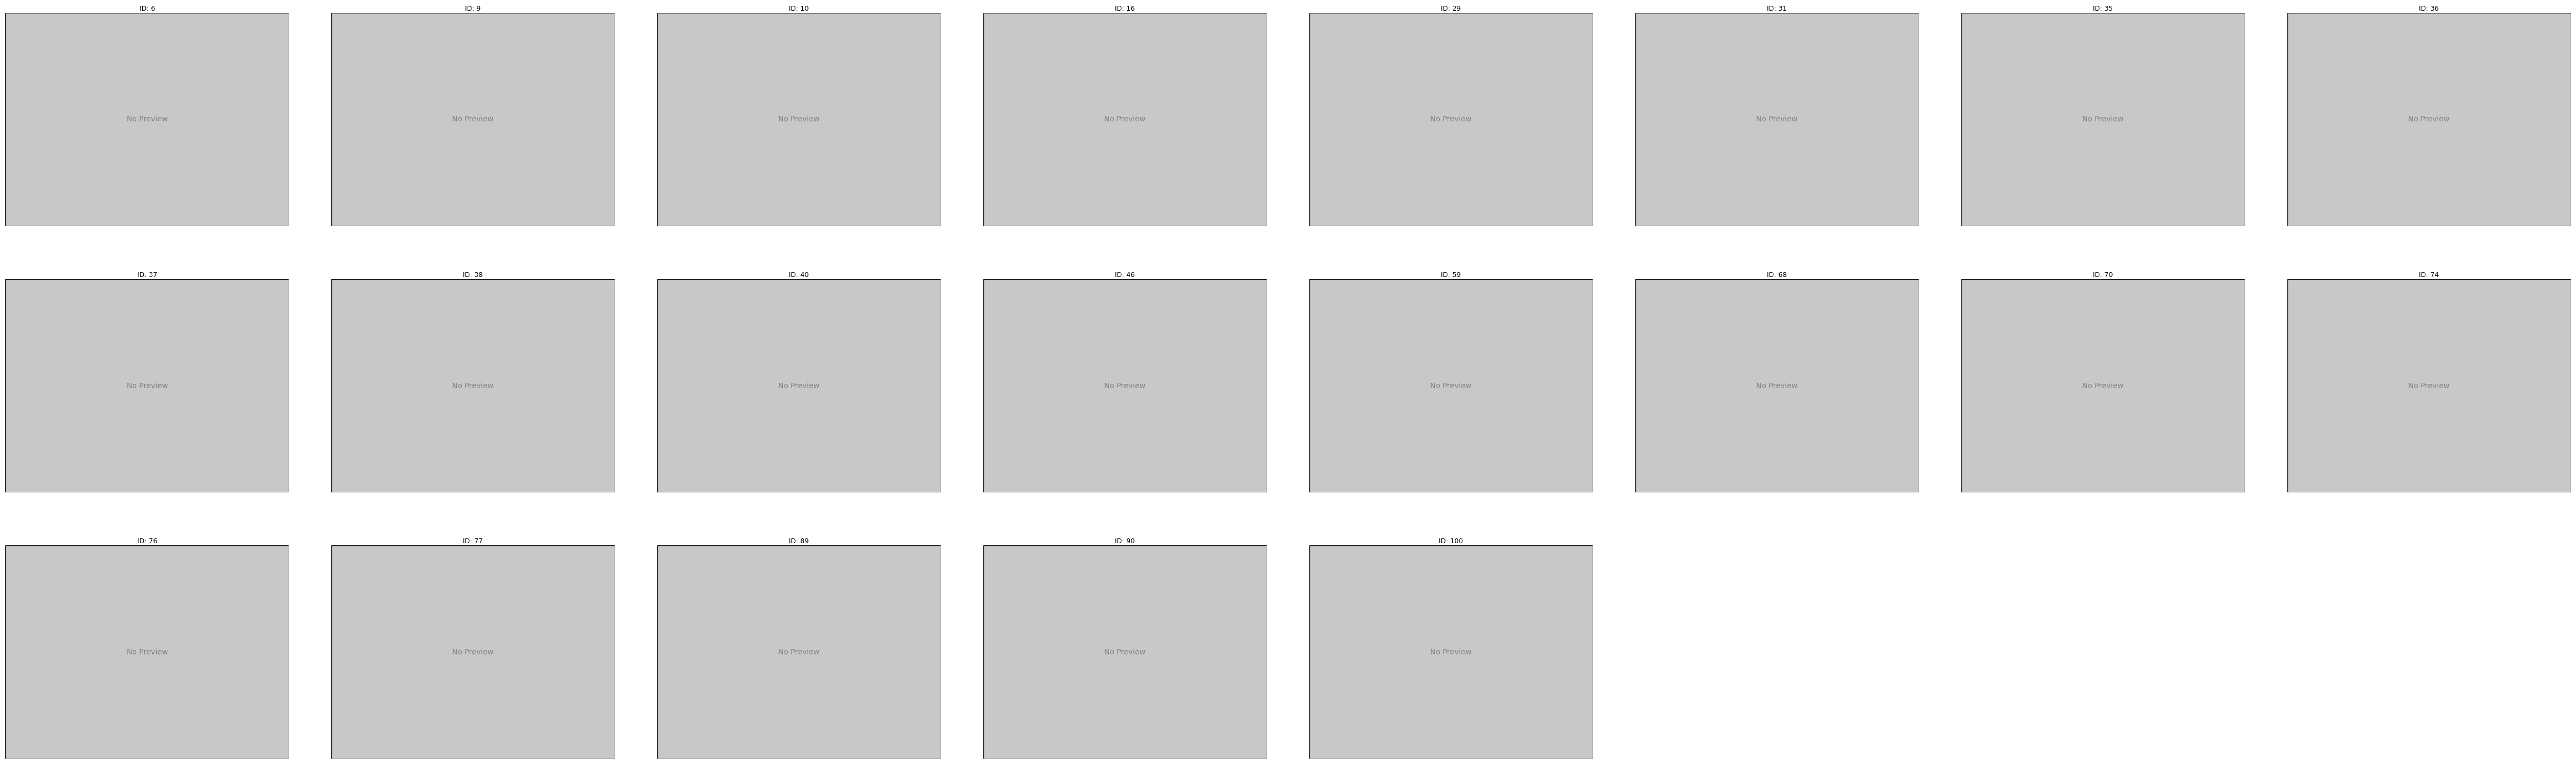

In [25]:
# Visualize the filtered files as a 5x5 grid with file IDs as labels
fig = dataset_viewer.show_preview_as_image(
    file_list, 
    k=len(file_list),                      # Show up to 25 files
    grid_cols=8,               # 5 columns
    figsize=(50, 15)           # Larger figure size
)

plt.show()